In [47]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.datasets import load_iris

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error

The prediction of a Linear Regression model is the value of a hypothesis function, which is the dot product between the parameter vector theta (containing bias term theta0 and weight terms theta1 to thetan) and the feature vector X, containing x0 to x1

Usually, the vectors are represented as column vectors, so it is commonly denoted as the dot product between tranposed theta vector and the feature vector X.

## The Normal Equation

The equation which calculates the value of vector theta which makes the cost function minimum. This vector is denoted as theta-bar 

Firstt, generate some linear data:

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100,1)

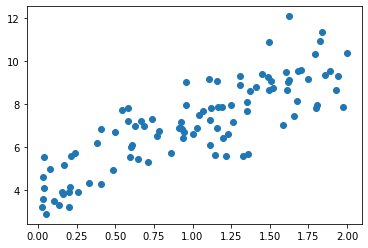

In [3]:
plt.scatter(X, y)

Since the dot product of 2 vectors is executed on every element, but since theta0 is supposed to be a constant, we will add x0 = 1 to the beginning of each instance vector so that when we perform the dot product operation, theta0 is always multiplied with 1.

In [4]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = LA.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.16495105],
       [2.93230496]])

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.16495105],
       [10.02956098]])

Plot the data and our prediction

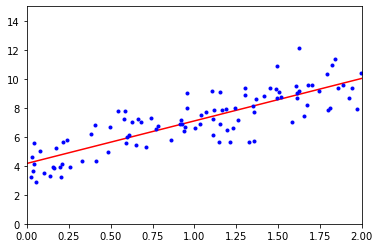

In [6]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

ValueError: illegal value in 4-th argument of internal None

Computing the best value of theta vector using lstsq() function of Scipy linalg

In [8]:
theta_best_svd, residuals, rank, s = LA.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.16495105],
       [2.93230496]])

Single Value Decomposition

Computing that vector using the pseudoinverse operation of matrix, which uses a standard matrix factorization technique named Singular Value Decomposition. This should produce the same result:

In [9]:
LA.pinv(X_b).dot(y)

array([[4.16495105],
       [2.93230496]])

## Gradient Descent

Batch gradient descent

In [10]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100 # number of instances

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[4.16495105],
       [2.93230496]])

Stochastic Gradient Descent with a learning schedule:

In [11]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hypterparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        
theta

array([[4.17633064],
       [2.85992165]])

In [12]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.16334495]), array([2.96929897]))

Mini-batch GD

## Polynomial regression

In [13]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

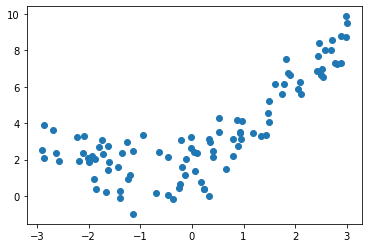

In [14]:
plt.scatter(X, y)

In [15]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.23496891]), array([-0.23496891,  0.05521039]))

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.8848405]), array([[0.97555948, 0.49066098]]))

the model estimates yˆ = 0.56x^2 + 0.93x + 1.78 when in fact the original function was y = 0.5x^2 + 1.0x + 2.0 + Gaussian noise.

In [19]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()

Examine the learning curves of different models

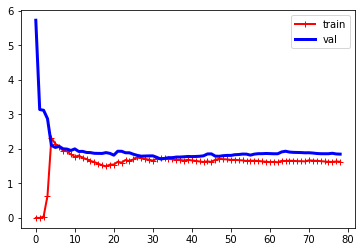

In [20]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

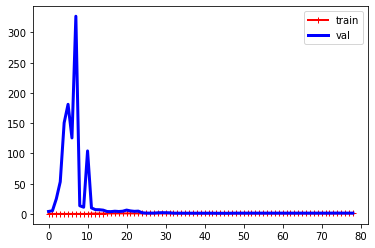

In [22]:
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)

## Regularized Linear Models

Ridge regression

In [26]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.01751206]])

In [27]:
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.01921177])

Lasso regression

In [29]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.97656686])

Elastic net, which is a combination of both

In [34]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.97435089])

## Early stopping

Generate some data:

In [39]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [40]:
# prepare the data
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

In [41]:
best_epoch, best_model

(243,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              tol=-inf, warm_start=True))

## Logistic regression

Regression computation makes use of the sigmoid function

In [45]:
iris = load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [49]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

In [55]:
log_reg = LogisticRegression() # l2 penalty by default
log_reg.fit(X, y);

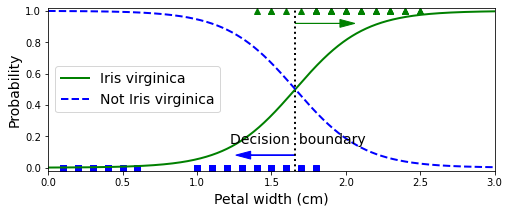

In [56]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [59]:
decision_boundary

array([1.66066066])

Which is why the prediction of this model is as follows:

In [57]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

## Softmax regression

In [69]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
softmax_reg.fit(X, y);

In [62]:
softmax_reg.predict([[5, 2]])

array([2])

In [67]:
np.unique(y)

array([0, 1, 2])

It reached to the above conclusion with the following confidence:

In [63]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

## Fine-tuning parameters:

Using SGD regression model with penalty hyperparameter set to be L1 to simulate Lasso regression model when working with a randomly generated dataset above:

In [31]:
sgd_reg = SGDRegressor(penalty='l1')
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

array([4.98678756])

When experiment with parameters of the following models, I will use the accuracy score as a metric of evaluation.

In [74]:
from sklearn.model_selection import cross_val_score

Experiment with Softmax regression:

First, let's reuse the model in the chapter with the exactly same hyperparameter to evaluate its accuracy first because it wasn't mentioned in the chapter:

In [76]:
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
scores = cross_val_score(softmax_reg, X, y, scoring='accuracy')
scores.mean()

0.96

In [78]:
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=100)
scores = cross_val_score(softmax_reg, X, y, scoring='accuracy')
scores.mean()

0.9533333333333334

In [79]:
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=1000)
scores = cross_val_score(softmax_reg, X, y, scoring='accuracy')
scores.mean()

0.9533333333333334

As can be seen clearly, I increased the C hyperparameter (regularization strength) exponentially and it makes the performance of the model decreased gradually. Next, we'll experiment with the usual Logistic regression classifiers.

Transforming the dataset to suit a binary classsification task for experimenting with Logistic regression

In [81]:
X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(np.int)

In [85]:
log_reg = LogisticRegression()
scores = cross_val_score(log_reg, X, y, scoring='accuracy')
scores.mean()

0.9533333333333334

In [93]:
log_reg = LogisticRegression(solver='saga', C=100)
scores = cross_val_score(log_reg, X, y, scoring='accuracy')
scores.mean()

0.9600000000000002

However, the observation with Softmax Regression above is no longer the case as when I increased C and changed the solver to be 'saga', the performance of this Logistic Regression model increased slightly.